In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math

# Load MATLAB data.
data = scipy.io.loadmat('dataset2.mat')
t = data['t']
x_true = data['x_true']
y_true = data['y_true']
th_true = data['th_true']
true_valid = data['true_valid']
l = data['l']
r = data['r']
sigma_rk = data['r_var'][0][0]
b = data['b']
sigma_phik = data['b_var'][0][0]
v = data['v']
w_v_k = data['v_var'][0][0]
om = data['om']
w_om_k = data['om_var'][0][0]
d = data['d'][0][0]

# Constants.
T = 0.1
datasize = t.shape[0]
x_l = l[:, 0]
y_l = l[:, 1]

# Initial values.
X_true = np.array([[x_true[0][0]], [y_true[0][0]], [th_true[0][0]]]) # Bad initials: np.array([[1],[1],[0.1]]).
P_h_k = np.diag([1, 1, 0.1])
X_h_k = np.array([[x_true[0][0]], [y_true[0][0]], [th_true[0][0]]]) # Bad initials: np.array([[1],[1],[0.1]]).

# For true states.
# ---
#X_true_st = np.array([[x_true[:,0]], [y_true[:,0]], [th_true[:,0]]])
# ---

# EKF.
r_max = 5 #5, 3, 1

X_h = []
P_h = []

# Filter omega.
def omfil(x):
    return (x + np.pi) % (2*np.pi) - np.pi

for i in range(datasize):

    G = []
    y = []
    g = []

    # Jacobians.
    F_kp = np.array([[1, 0, -T * v[i][0] * np.sin(float(X_h_k[2][0]))], 
                     [0, 1, T * v[i][0] * np.cos(float(X_h_k[2][0]))], 
                     [0, 0, 1]])
    # For true states.
    # ---
    #F_kp = np.array([[1, 0, -T * v[i][0] * np.sin(float(X_true_st[2][0][i]))], 
                     #[0, 1, T * v[i][0] * np.cos(float(X_true_st[2][0][i]))], 
                     #[0, 0, 1]])
    # ---

    # Covariance Matrices.
    Q11 = T**2 * w_v_k**2 * np.cos(X_h_k[2][0])**2
    Q12 = T**2 * w_v_k**2 * np.cos(X_h_k[2][0]) * np.sin(X_h_k[2][0])
    Q21 = T**2 * w_v_k**2 * np.sin(X_h_k[2][0]) * np.cos(X_h_k[2][0])
    Q22 = T**2 * w_v_k**2 * np.sin(X_h_k[2][0])**2
    Q33 = T**2 * w_om_k**2
    # For true states.
    # ---
    #Q11 = T**2 * w_v_k**2 * np.cos(X_true_st[2][0][i])**2
    #Q12 = T**2 * w_v_k**2 * np.cos(X_true_st[2][0][i]) * np.sin(X_true_st[2][0][i])
    #Q21 = T**2 * w_v_k**2 * np.sin(X_true_st[2][0][i]) * np.cos(X_true_st[2][0][i])
    #Q22 = T**2 * w_v_k**2 * np.sin(X_true_st[2][0][i])**2
    #Q33 = T**2 * w_om_k**2
    # ---
    Q_pr = np.array([[Q11, Q12, 0],
                     [Q21, Q22, 0],
                     [0, 0, Q33]])
    # EKF algorithm.
    P_c_k = F_kp @ P_h_k @ np.transpose(F_kp) + Q_pr
    X_c1 = X_h_k[0][0] + T * (v[i][0]) * np.cos(X_h_k[2][0])
    X_c2 = X_h_k[1][0] + T * (v[i][0]) * np.sin(X_h_k[2][0])
    X_c3 = X_h_k[2][0] + T * (om[i][0])
    # For true states.
    # ---
    #X_c1 = X_true_st[0][0][i] + T * (v[i][0]) * np.cos(X_true_st[2][0][i])
    #X_c2 = X_true_st[1][0][i] + T * (v[i][0]) * np.sin(X_true_st[2][0][i])
    #X_c3 = X_true_st[2][0][i] + T * (om[i][0])
    # ---
    X_c_k = np.array([[X_c1], [X_c2], [X_c3]])
    X_c_k[2] = omfil(X_c_k[2])

    # Innovarion and threshold.
    r_count = 0
    for j in range(16):
        if r[i][j] == 0 or r[i][j] > r_max:
            continue
        r_count += 1

        X_c = x_l[j] - X_c_k[0][0] - d * np.cos(X_c_k[2][0])
        Y_c = y_l[j] - X_c_k[1][0] - d * np.sin(X_c_k[2][0])

        # G_k.
        G11 = -X_c / np.sqrt(X_c**2 + Y_c**2)
        G12 = -Y_c / np.sqrt(X_c**2 + Y_c**2)
        G13 = (X_c * d * np.sin(X_c_k[2][0]) - Y_c * d * np.cos(X_c_k[2][0])) / np.sqrt(X_c**2 + Y_c**2)
        G21 = Y_c / (X_c**2 + Y_c**2)
        G22 = -X_c / (X_c**2 + Y_c**2)
        G23 = (-d * X_c * np.cos(X_c_k[2][0]) - d * Y_c * np.sin(X_c_k[2][0])) / (X_c**2 + Y_c**2)
        G_ck = np.array([[G11, G12, G13], [G21, G22, G23-1]])
        y_ck = np.array([[r[i][j]], [b[i][j]]])
        g1 = np.sqrt(X_c**2 + Y_c**2)
        g2 = omfil(np.arctan2(Y_c, X_c) - X_c_k[2][0])
        g_ck = np.vstack((g1, g2))
        G.append(G_ck)
        y.append(y_ck)
        g.append(g_ck)
        
            
    if r_count != 0:
        g_c_k = np.vstack(g)
        y_k = np.vstack(y)
        G_k = np.vstack(G)
        R_pr = np.diag([sigma_rk.item(), sigma_phik.item()] * r_count)
        K_k = P_c_k @ np.transpose(G_k) @ np.linalg.inv(G_k @ P_c_k @ np.transpose(G_k) + R_pr)
        P_h_k = (np.eye(3) - K_k @ G_k) @ P_c_k
        X_h_k = X_c_k + K_k @ (y_k - g_c_k)
        X_h_k[2] = omfil(X_h_k[2])
        
    else:
        P_h_k = P_c_k
        X_h_k = X_c_k
    X_h.append(X_h_k)
    P_h.append(P_h_k)

Text(0, 0.5, 'Error')

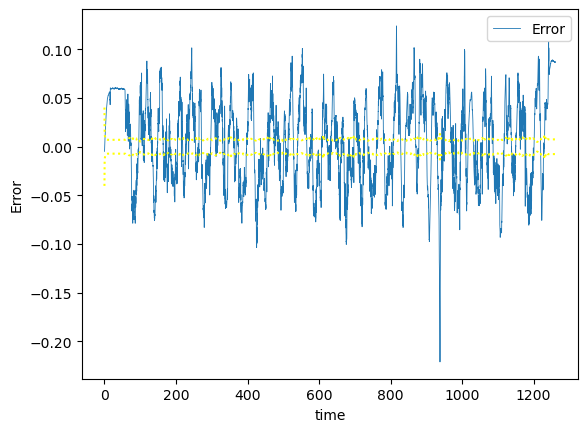

In [47]:
# Calculating error.
error_x = np.array(X_h)[:,0] - x_true
error_y = np.array(X_h)[:,1] - y_true
error_th = np.array(X_h)[:,2] - th_true

# Calculating uncertainty envelope.
var_x = np.array(P_h)[:,0,0]
unc_env_x = 3 * np.sqrt(var_x)
var_y = np.array(P_h)[:,1,1]
unc_env_y = 3 * np.sqrt(var_y)
var_th = np.array(P_h)[:,2,2]
unc_env_th = 3 * np.sqrt(var_th)

# Plot for x.
plt.plot(t, error_x, label='Error', linewidth=0.6)
plt.plot(t, -unc_env_x, linestyle=':', color='yellow')
plt.plot(t, unc_env_x, linestyle=':', color='yellow')
plt.legend()
plt.xlabel('time')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

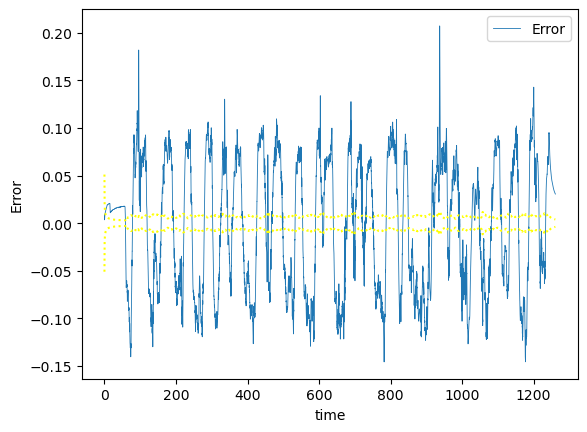

In [48]:
# Plot for y.
plt.plot(t, error_y, label='Error', linewidth=0.6)
plt.plot(t, -unc_env_y, linestyle=':', color='yellow')
plt.plot(t, unc_env_y, linestyle=':', color='yellow')
plt.legend()
plt.xlabel('time')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

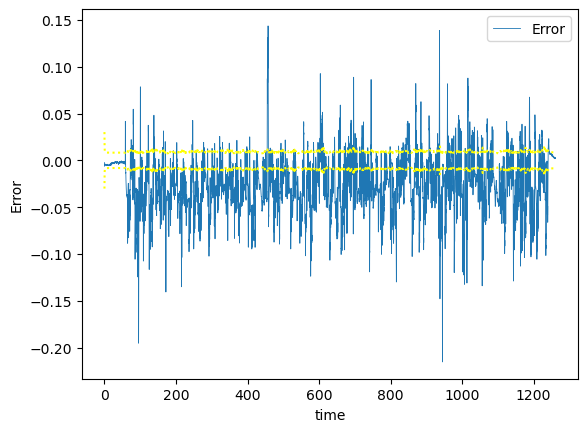

In [49]:
# Plot for theta.
plt.plot(t, np.arctan2(np.sin(error_th), np.cos(error_th)), label='Error', linewidth=0.6)
plt.plot(t, -unc_env_th, linestyle=':', color='yellow')
plt.plot(t, unc_env_th, linestyle=':', color='yellow')
plt.legend()
plt.xlabel('time')
plt.ylabel('Error')

C:\Users\Max\AppData\Local\Temp\ipykernel_22076\438767808.py:39: MatplotlibDeprecationWarning: 
The modification of the Axes.patches property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.patches[:]


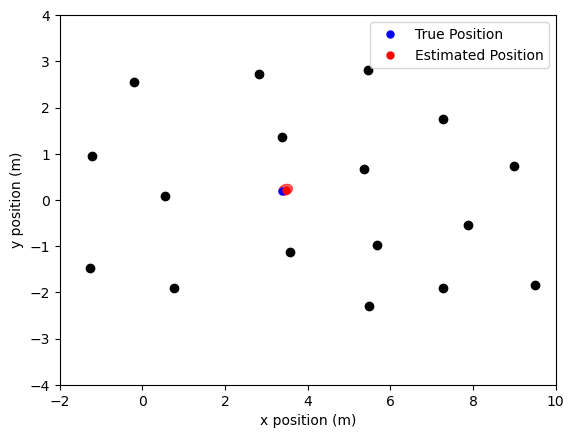

In [50]:
# Animation.
from matplotlib.animation import FuncAnimation, writers
from matplotlib.patches import Ellipse
from scipy.stats import chi2

sigma = np.sqrt(np.abs(P_h))

fig, ax = plt.subplots()
ax.set_xlim(-2, 10)
ax.set_ylim(-4, 4)
X_t, = ax.plot([], [], 'o', color='b', ms=5, label="True Position")
X_EKF, = ax.plot([], [], 'o', color='r', ms=5, label="Estimated Position")
ax.scatter(x_l, y_l, color='k')
ax.legend()
ax.set_ylabel("y position (m)")
ax.set_xlabel("x position (m)")

def ellipse(gap):
        covar = sigma[gap, 0:2, 0:2]
        center = (np.array(X_h)[:,0][gap], np.array(X_h)[:,1][gap])

        # Singular value decomp. to get eigenvalues and eigenvectors. (https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm#:~:text=The%20SVD%20represents%20an%20expansion,up%20the%20columns%20of%20U.)
        U, S, Vh = np.linalg.svd(covar)
        # Using chi square to calculate the dimensions of this ellipse. (https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/)
        chi = chi2.isf(1 - 0.995, 2)
        width = 2.0 * math.sqrt(S[0] * chi)
        height = 2.0 * math.sqrt(S[1] * chi)
        angle = math.atan2(U[1][0], U[0][0]) * 180 / math.pi

        return Ellipse(xy=center, width=width, height=height, angle=angle, alpha=0.6,
                       color='r', zorder=-1)

def animate(i):

    gap = int(i.item()*10)
    X_EKF.set_data(np.array(X_h)[:,0][gap], np.array(X_h)[:,1][gap])
    X_t.set_data(x_true[gap], y_true[gap])

    del ax.patches[:]
    ax.add_patch(ellipse(gap))
    
ani = FuncAnimation(fig, animate, interval = 10, frames = t)
ani.save('Assign2_Animation.mp4', writer=writers['ffmpeg'](fps=30))
